In [ ]:
!pip install catboost
!pip install optuna
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.1 MB/s eta 0:00:00


In [ ]:
# Standard python libraries
from google.colab import drive
import os
import sys
import time
import yaml
import joblib
from functools import partial
import warnings
warnings.filterwarnings('ignore')
# Essential DS libraries
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve,roc_auc_score,average_precision_score,auc,accuracy_score
from sklearn.base import BaseEstimator
from sklearn.calibration import CalibratedClassifierCV,CalibrationDisplay,calibration_curve
from sklearn.model_selection import TimeSeriesSplit

import optuna
import shap
from catboost import CatBoostClassifier, Pool, cv

In [ ]:
def binary_model_metric_perfomance(model,pool,threshold=0.5):

#     получение предсказаний на automl lama model по датасету и reshape чтобы получить вектор
    pred_proba = model.predict_proba(pool)[:,1].reshape(-1)
    pred = (pred_proba >= threshold).astype(int)

    pred_distrib = np.unique(pred,return_counts=True)

    target = pool.get_label()
    target_distrib = np.unique(target,return_counts=True)

    target_classes = {f"target_label_count_{target_distrib[0][i]}" : target_distrib[1][i] for i in range(len(target_distrib[0]))}
    pred_classes = {f"pred_label_count_{pred_distrib[0][i]}" : pred_distrib[1][i] for i in range(len(pred_distrib[0]))}


    binary_metrics = {
            'N': len(pred),
            'accuracy' : accuracy_score(target,pred),
            'precision' : precision_score(target,pred),
            'recall' : recall_score(target,pred),
            'f1' : f1_score(target,pred),
            'roc-auc' : roc_auc_score(target,pred_proba),
            'gini' : 2 * roc_auc_score(target,pred_proba) - 1,
            'pr-auc' : average_precision_score(target,pred_proba),
            'threshold' : threshold,
        }

    binary_metrics.update(target_classes)
    binary_metrics.update(pred_classes)

    return binary_metrics

# Загрузка данных и конфига

In [ ]:
if 'drive' not in os.listdir():
    drive.mount('/content/drive')
# основные пути и файлы
working_path = '/content/drive/MyDrive/risk_project_1'
data_path = os.path.join(working_path,'data')
model_path = os.path.join(working_path,'models')
model_name = 'catboost'

train_file = 'catboost_train.csv'
oos_file = 'catboost_oos.csv'
oot_file = 'catboost_oot.csv'
config_file = 'catboost_data_config.yml'
# конфиг датасета
with open(os.path.join(working_path,config_file),'r',encoding='utf-8') as config:
    data_config = yaml.full_load(config)

# данные
train = pd.read_csv(os.path.join(data_path,train_file)).fillna(dict(zip(data_config['roles']['category'],['None'] * len(data_config['roles']['category'])))) \
              .sort_values(data_config['time_col'])
train_pool = Pool(train.drop(columns = data_config['roles']['drop'] + [data_config['roles']['target']]),
                  label=train[data_config['roles']['target']],
                  cat_features=data_config['roles']['category'])

oos = pd.read_csv(os.path.join(data_path,oos_file)).fillna(dict(zip(data_config['roles']['category'],['None'] * len(data_config['roles']['category']))))
oos_pool = Pool(oos.drop(columns = data_config['roles']['drop'] + [data_config['roles']['target']]),
                  label=oos[data_config['roles']['target']],
                  cat_features=data_config['roles']['category'])

oot = pd.read_csv(os.path.join(data_path,oot_file)).fillna(dict(zip(data_config['roles']['category'],['None'] * len(data_config['roles']['category']))))
oot_pool = Pool(oot.drop(columns = data_config['roles']['drop'] + [data_config['roles']['target']]),
                  label=oot[data_config['roles']['target']],
                  cat_features=data_config['roles']['category'])

print('Фичи для обучения:')
print(train_pool.get_feature_names())

Mounted at /content/drive
Фичи для обучения:
['addr_state', 'all_util', 'annual_inc', 'bc_open_to_buy', 'dti', 'emp_length', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'installment', 'last_fico_range_high', 'last_fico_range_low', 'loan_amnt', 'mo_sin_old_rev_tl_op', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'open_il_12m', 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'revol_util', 'term', 'tot_cur_bal', 'total_acc']


In [ ]:
print('Проверка на не пересечение дат')
print('Даты в oot')
display(pd.to_datetime(oot[data_config['time_col']]).describe())
print('Даты в oos')
display(pd.to_datetime(oos[data_config['time_col']]).describe())
print('Даты в train')
display(pd.to_datetime(train[data_config['time_col']]).describe())

Проверка на не пересечение дат
Даты в oot


count                  298139
unique                      7
top       2018-10-01 00:00:00
freq                    46305
first     2018-06-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

Даты в oos


count                  432954
unique                     53
top       2016-03-01 00:00:00
freq                    15554
first     2014-01-01 00:00:00
last      2018-05-01 00:00:00
Name: issue_d, dtype: object

Даты в train


count                 1298859
unique                     53
top       2016-03-01 00:00:00
freq                    46438
first     2014-01-01 00:00:00
last      2018-05-01 00:00:00
Name: issue_d, dtype: object

# Обучение базовой модели и модели с подбором гиперпараметров



In [ ]:
%%time
# базовая модель с классическими параметрами
simple_cb_model = CatBoostClassifier(
    objective = 'CrossEntropy',
    random_seed = data_config['random_state'],
    iterations = 1000,
    custom_loss='AUC',
    task_type='GPU',
    verbose = 500,
)
simple_cb_model.fit(train_pool)

# сохраним модель
with open(os.path.join(model_path,'simple_' + model_name + '.pkl'),'wb') as save_model:
    joblib.dump(simple_cb_model,save_model)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.6494025	total: 104ms	remaining: 1m 44s
500:	learn: 0.1896733	total: 1m 17s	remaining: 1m 17s
999:	learn: 0.1881676	total: 2m 3s	remaining: 0us
CPU times: user 1min 39s, sys: 18.6 s, total: 1min 58s
Wall time: 2min 10s


In [ ]:
# для графика обучения модели
# model = joblib.load(os.path.join(model_path,'simple_' + model_name + '.pkl'))
# evals_result = model.get_evals_result()
# train_loss = evals_result['learn']['CrossEntropy']

# # Plot the training progress
# iterations = np.arange(1, len(train_loss) + 1)

# plt.figure(figsize=(7, 4))
# plt.plot(iterations, train_loss, label='Training Loss', color='blue')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.title('CatBoost Training Progress')
# plt.legend()
# plt.grid()
# plt.show()
# график анализа фичи
# model = joblib.load(os.path.join(model_path,'simple_' + model_name + '.pkl'))
# feature_name = 'annual_inc'
# stats = model.calc_feature_statistics(data=train_pool,
#                         target=train_pool.get_label(),
#                         feature=feature_name,
#                         prediction_type='Probability',
#                         cat_feature_values=None,
#                         plot_file=f"{feature_name}.html")

## Оценка cross val score на TimeSeries split для базовой модели

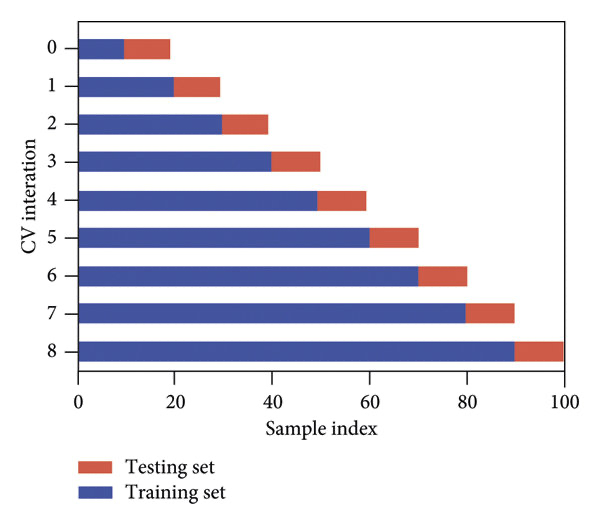

In [ ]:
# посмотрим на небольших итерациях чтобы быстрее было
params = dict(
    objective = 'CrossEntropy',
    random_seed = data_config['random_state'],
    iterations = 20,
    custom_loss='AUC',
    eval_metric='AUC',
    task_type='CPU'
)
# заранее отсортировали данные в train для корректности cv
tscv = TimeSeriesSplit(n_splits=10)
cv_data = cv(
    params = params,
    pool = train_pool,
    verbose = False,
    folds = tscv,
    plot=True
)
print('Mean validation AUC score on Time Series Split: {:.4f}±{:.4f}'.format(
        cv_data['test-AUC-mean'].mean(),
        cv_data['test-AUC-std'].mean())
    )
cv_data

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]

bestTest = 0.9329109603
bestIteration = 19

Training on fold [1/10]

bestTest = 0.93983111
bestIteration = 18

Training on fold [2/10]

bestTest = 0.9472704007
bestIteration = 15

Training on fold [3/10]

bestTest = 0.9466509448
bestIteration = 17

Training on fold [4/10]

bestTest = 0.9487469409
bestIteration = 16

Training on fold [5/10]

bestTest = 0.9425258922
bestIteration = 17

Training on fold [6/10]

bestTest = 0.9396164538
bestIteration = 19

Training on fold [7/10]

bestTest = 0.9317006637
bestIteration = 7

Training on fold [8/10]

bestTest = 0.9120478839
bestIteration = 13

Training on fold [9/10]

bestTest = 0.8895480832
bestIteration = 19

Mean validation AUC score on Time Series Split: 0.9301±0.0215


,iterations,test-AUC-mean,test-AUC-std,test-CrossEntropy-mean,test-CrossEntropy-std,train-CrossEntropy-mean,train-CrossEntropy-std
0,0,0.920658,0.024272,0.648715,0.003530,0.651735,0.001533
1,1,0.926431,0.024366,0.607863,0.006373,0.613624,0.002439
2,2,0.927887,0.024407,0.571327,0.010054,0.579686,0.004442
3,3,0.927951,0.024424,0.538933,0.012475,0.549563,0.005134
4,4,0.928462,0.023716,0.509599,0.015159,0.522187,0.006430
5,5,0.929022,0.023533,0.482338,0.016458,0.496754,0.006432
6,6,0.929589,0.023622,0.458226,0.018553,0.474330,0.007366
7,7,0.929499,0.023770,0.436629,0.020226,0.454263,0.008139
8,8,0.930474,0.020886,0.417062,0.022038,0.436110,0.008917
9,9,0.930565,0.021210,0.398395,0.023073,0.418785,0.009105


## Тюнинг модели

In [ ]:
%%time
# для тюнинга параметров
train_mask = train[data_config['time_col']] < data_config['val_time_border']
val_mask = (train[data_config['time_col']] >= data_config['val_time_border']) & (train[data_config['time_col']] < data_config['test_time_border'])

optuna_train = Pool(train.loc[train_mask].drop(columns = data_config['roles']['drop'] + [data_config['roles']['target']]),
                  label=train.loc[train_mask][data_config['roles']['target']],
                  cat_features=data_config['roles']['category'])

optuna_val = Pool(train.loc[val_mask].drop(columns = data_config['roles']['drop'] + [data_config['roles']['target']]),
                  label=train.loc[val_mask][data_config['roles']['target']],
                  cat_features=data_config['roles']['category'])

# тюнинг параметров
def objective(trial):
    params = {
        "objective" : trial.suggest_categorical("objective", ["CrossEntropy"]),
        "learning_rate" : trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg" : trial.suggest_loguniform("l2_leaf_reg", 1e-2, 3e0),
        "depth" : trial.suggest_int("depth", 2, 5),
        "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", 2, 50, 4),
        "one_hot_max_size" : trial.suggest_int("one_hot_max_size", 2, 50, 4),
        "iterations" : trial.suggest_int("iterations", 200,1000, 100),
        "eval_metric" : "AUC"
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log = True)

    model = CatBoostClassifier(
        random_seed = data_config['random_state'],
        task_type = 'GPU',
        use_best_model = True,
        verbose = False,
        early_stopping_rounds=10,
        custom_loss='AUC',
        **params
    )

    model.fit(optuna_train,eval_set = optuna_val)

    y_pred = model.predict_proba(optuna_val)[:, 1]
    roc_auc = roc_auc_score(optuna_val.get_label(), y_pred)

    return roc_auc

study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps = 3), direction = "maximize")
study.optimize(objective, n_trials = 10, timeout = 1200)

best_params = study.best_params

print("Best params:", best_params)

# переобучение модели на лучших параметрах
tuned_cb_model = CatBoostClassifier(
    random_seed = data_config['random_state'],
    task_type = 'GPU',
    verbose = 100,
    **best_params
)
tuned_cb_model.fit(train_pool)

# сохраним модель
with open(os.path.join(model_path,'tuned_' + model_name + '.pkl'),'wb') as save_model:
    joblib.dump(tuned_cb_model,save_model)

[I 2024-03-18 19:23:55,158] A new study created in memory with name: no-name-f0b88bb8-2f45-4e3a-b0ea-e42a34fb9296
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-03-18 19:23:59,659] Trial 0 finished with value: 0.8646109364393184 and parameters: {'objective': 'CrossEntropy', 'learning_rate': 0.00014337693637532758, 'l2_leaf_reg': 0.12580800798340588, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 26, 'one_hot_max_size': 38, 'iterations': 200}. Best is trial 0 with value: 0.8646109364393184.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-03-18 19:24:03,081] Trial 1 finished with value: 0.8695062453483349 and parameters: {'objective': 'CrossEntropy', 'learning_rate': 0.03409177505170649, 'l2_leaf_reg': 0.07315977987738322, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 46, 'one_hot_max_size': 14, 'iterations': 1000}. Best is trial 1 with value: 0.8695062453

Best params: {'objective': 'CrossEntropy', 'learning_rate': 0.37182210910513125, 'l2_leaf_reg': 2.0156712187273444, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 2, 'one_hot_max_size': 42, 'iterations': 600, 'subsample': 0.15760011466824206}
0:	learn: 0.3286909	total: 134ms	remaining: 1m 20s
100:	learn: 0.1899536	total: 10.8s	remaining: 53.3s
200:	learn: 0.1890760	total: 21.4s	remaining: 42.5s
300:	learn: 0.1885709	total: 30.7s	remaining: 30.5s
400:	learn: 0.1882261	total: 42.6s	remaining: 21.2s
500:	learn: 0.1879500	total: 52.9s	remaining: 10.5s
599:	learn: 0.1876676	total: 1m 2s	remaining: 0us
CPU times: user 2min 33s, sys: 20 s, total: 2min 53s
Wall time: 2min 27s


# Быстрая оценка модели и выбор между обычно и тюнингованной моделью

In [ ]:
target = data_config['roles']['target']

simple_train_pred = simple_cb_model.predict_proba(train_pool)[:,1]
simple_oos_pred = simple_cb_model.predict_proba(oos_pool)[:,1]
simple_oot_pred = simple_cb_model.predict_proba(oot_pool)[:,1]

tuned_train_pred = tuned_cb_model.predict_proba(train_pool)[:,1]
tuned_oos_pred = tuned_cb_model.predict_proba(oos_pool)[:,1]
tuned_oot_pred = tuned_cb_model.predict_proba(oot_pool)[:,1]

# Выбор лучшего порога


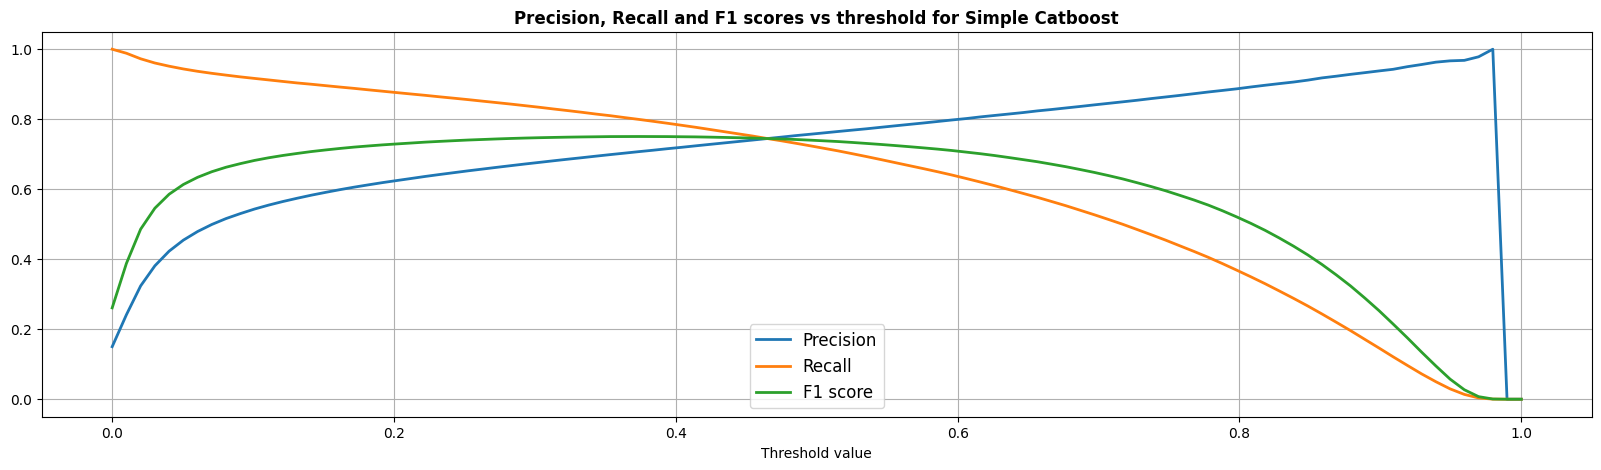

In [ ]:
tr = np.linspace(0, 1, 100)

p = np.zeros_like(tr)
r = np.zeros_like(tr)
f = np.zeros_like(tr)

for k, x in enumerate(tr):
    p[k] = precision_score(train_pool.get_label(),(simple_train_pred >= x).astype(int))
    r[k] = recall_score(train_pool.get_label(),(simple_train_pred >= x).astype(int))
    f[k] = f1_score(train_pool.get_label(),(simple_train_pred >= x).astype(int))

simple_best_thr = tr[np.argmax(f)]

fig = plt.figure(figsize=(20, 5))

plt.plot(tr, p, linewidth=2)
plt.plot(tr, r, linewidth=2)
plt.plot(tr, f, linewidth=2)

plt.title("Precision, Recall and F1 scores vs threshold for Simple Catboost", weight="bold")
plt.xlabel("Threshold value")
plt.legend(['Precision', 'Recall', 'F1 score'], fontsize=12)
plt.grid()
plt.show()

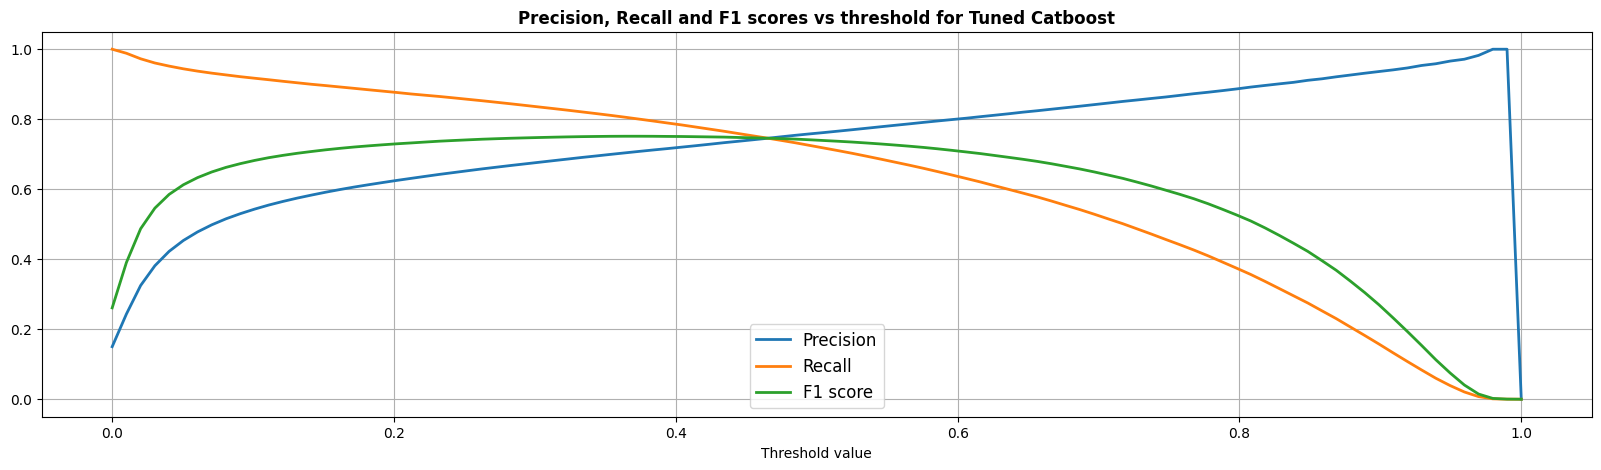

In [ ]:
tr = np.linspace(0, 1, 100)

p = np.zeros_like(tr)
r = np.zeros_like(tr)
f = np.zeros_like(tr)

for k, x in enumerate(tr):
    p[k] = precision_score(train_pool.get_label(),(tuned_train_pred >= x).astype(int))
    r[k] = recall_score(train_pool.get_label(),(tuned_train_pred >= x).astype(int))
    f[k] = f1_score(train_pool.get_label(),(tuned_train_pred >= x).astype(int))

tuned_best_thr = tr[np.argmax(f)]

fig = plt.figure(figsize=(20, 5))

plt.plot(tr, p, linewidth=2)
plt.plot(tr, r, linewidth=2)
plt.plot(tr, f, linewidth=2)

plt.title("Precision, Recall and F1 scores vs threshold for Tuned Catboost", weight="bold")
plt.xlabel("Threshold value")
plt.legend(['Precision', 'Recall', 'F1 score'], fontsize=12)
plt.grid()
plt.show()

# Общие метрики на каждом множестве.



In [ ]:
result_dict = {}
result_dict[f"train {target}"] = binary_model_metric_perfomance(simple_cb_model,train_pool,threshold=simple_best_thr)
result_dict[f"oos {target}"] = binary_model_metric_perfomance(simple_cb_model,oos_pool,threshold=simple_best_thr)
result_dict[f"oot {target}"] = binary_model_metric_perfomance(simple_cb_model,oot_pool,threshold=simple_best_thr)

result_df = []

for k,v in result_dict.items():
    type_dataset = k.split()[0]
    target_col = ' '.join(k.split()[1:])
    res = {'dataset': type_dataset, 'measurement' : target_col,}
    res.update(v)
    result_df.append(res)

result_df = pd.DataFrame(result_df)
print('Простой catboost')
display(result_df)
result_df.to_excel(os.path.join(model_path,'simple_' + model_name + '_metrics.xlsx'),index=False)

result_dict = {}
result_dict[f"train {target}"] = binary_model_metric_perfomance(tuned_cb_model,train_pool,threshold=tuned_best_thr)
result_dict[f"oos {target}"] = binary_model_metric_perfomance(tuned_cb_model,oos_pool,threshold=tuned_best_thr)
result_dict[f"oot {target}"] = binary_model_metric_perfomance(tuned_cb_model,oot_pool,threshold=tuned_best_thr)

result_df = []

for k,v in result_dict.items():
    type_dataset = k.split()[0]
    target_col = ' '.join(k.split()[1:])
    res = {'dataset': type_dataset, 'measurement' : target_col,}
    res.update(v)
    result_df.append(res)

result_df = pd.DataFrame(result_df)
print('tuned catboost')
display(result_df)
result_df.to_excel(os.path.join(model_path,'tuned_' + model_name + '_metrics.xlsx'),index=False)

Простой catboost


,dataset,measurement,N,accuracy,precision,recall,f1,roc-auc,gini,pr-auc,threshold,target_label_count_0,target_label_count_1,pred_label_count_0,pred_label_count_1
0,train,loan_condition_int,1298859,0.920288,0.707373,0.799492,0.750617,0.950399,0.900797,0.800450,0.373737,1103969,194890,1078589,220270
1,oos,loan_condition_int,432954,0.920033,0.707260,0.796903,0.749410,0.949277,0.898553,0.797037,0.373737,367990,64964,359756,73198
2,oot,loan_condition_int,298139,0.977588,0.591533,0.410712,0.484811,0.868542,0.737085,0.454247,0.373737,290484,7655,292824,5315


tuned catboost


,dataset,measurement,N,accuracy,precision,recall,f1,roc-auc,gini,pr-auc,threshold,target_label_count_0,target_label_count_1,pred_label_count_0,pred_label_count_1
0,train,loan_condition_int,1298859,0.920520,0.707985,0.800457,0.751387,0.950602,0.901205,0.801531,0.373737,1103969,194890,1078514,220345
1,oos,loan_condition_int,432954,0.919814,0.706259,0.797134,0.748950,0.948898,0.897796,0.795691,0.373737,367990,64964,359631,73323
2,oot,loan_condition_int,298139,0.977718,0.595472,0.412280,0.487225,0.866402,0.732804,0.453450,0.373737,290484,7655,292839,5300


# Shap values

## Simple Catboost

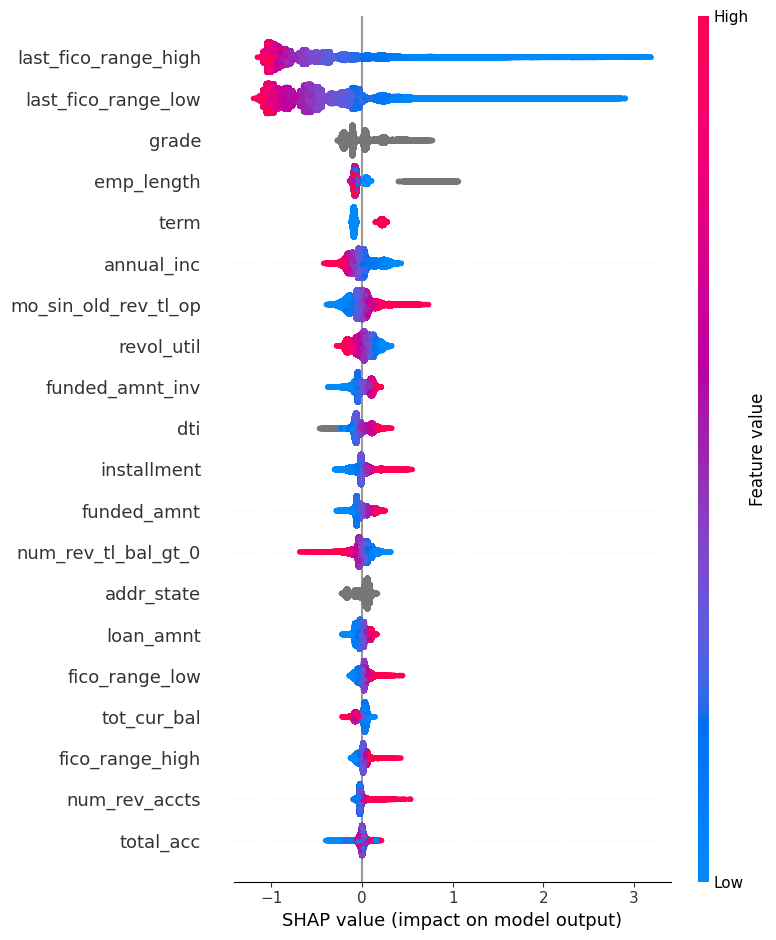

In [ ]:
shap_values = simple_cb_model.get_feature_importance(oot_pool, type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, oot.drop(columns = data_config['roles']['drop'] + [data_config['roles']['target']]))

## Tuned Catboost

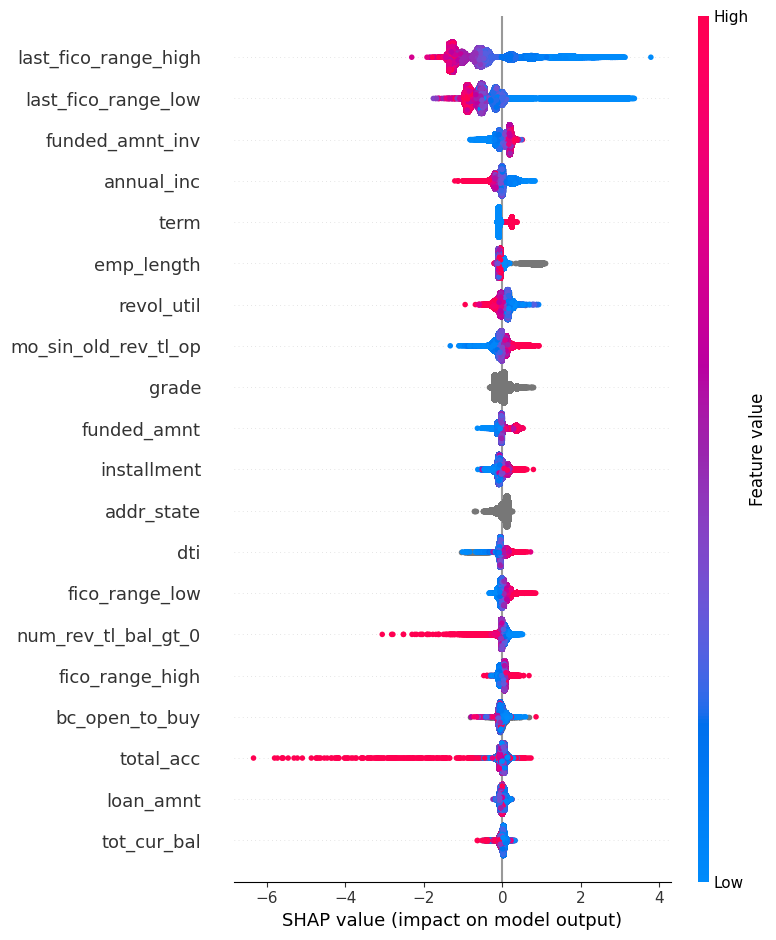

In [ ]:
shap_values = tuned_cb_model.get_feature_importance(oot_pool, type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, oot.drop(columns = data_config['roles']['drop'] + [data_config['roles']['target']]))

# Данные для пункта 6

In [ ]:
cols = [data_config['id_col'],data_config['time_col'],data_config['roles']['target'],'funded_amnt']
task_6_train = train[cols]
task_6_train['pred'] = simple_cb_model.predict_proba(train_pool)[:,1]
task_6_train['sample'] = 'train'

task_6_oos = oos[cols]
task_6_oos['pred'] = simple_cb_model.predict_proba(oos_pool)[:,1]
task_6_oos['sample'] = 'oos'

task_6_oot = oot[cols]
task_6_oot['pred'] = simple_cb_model.predict_proba(oot_pool)[:,1]
task_6_oot['sample'] = 'oot'

pd.concat([task_6_train,task_6_oos,task_6_oot]).reset_index(drop=True).to_csv(os.path.join(data_path,'task_6.csv'),index=False)